In [18]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import early_stopping

## 데이터 로드

In [9]:
train_df = pd.read_csv('C:/Users/jeonghwanlee/Downloads/train.csv')
test_df = pd.read_csv('C:/Users/jeonghwanlee/Downloads/test.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### 데이터 전처리

In [10]:
train_df = train_df.drop(['id','Surname'], axis=1)
train_df.duplicated().sum()

30

In [5]:
# train_df[train_df.duplicated(keep=False)].head(25)

In [11]:
train_df.drop_duplicates(inplace = True)
train_df.dropna(inplace=True)

In [12]:
train_df = train_df.drop(['CustomerId'], axis = 1)
train_df_encoded = pd.get_dummies(train_df, columns=['Geography','Gender'])
train_df_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.0,2,1.0,0.0,181449.97,0,True,False,False,False,True
1,627,33.0,1,0.0,2,1.0,1.0,49503.50,0,True,False,False,False,True
2,678,40.0,10,0.0,2,1.0,0.0,184866.69,0,True,False,False,False,True


## 데이터 나누기

In [13]:
X = train_df_encoded.drop('Exited', axis = 1)
y = train_df_encoded['Exited']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132003, 13), (33001, 13), (132003,), (33001,))

In [14]:
y_train.value_counts()

Exited
0    104112
1     27891
Name: count, dtype: int64

### 모델 성능 출력 함수

In [5]:
def get_clf_eval(y_test, pred, pred_proba):
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    
    # confusion = confusion_matrix(y_test, pred)
    
    # print("=> confusion matrix")
    # print(confusion)
    # print('===========')

    # print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    # print('Recall : {0:.4f}, F1: {1:.4f}, ROC_AUC: {2:.4f}'.format(re, f1, auc))
    return acc, pre, re, f1, auc

In [4]:
def print_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred, pred_proba)

    print("=> confusion matrix")
    print(confusion)
    print('===========')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    print('Recall : {0:.4f}, F1: {1:.4f}, ROC_AUC: {2:.4f}'.format(re, f1, auc))

### 모델별 결과 정리 함수

In [6]:
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    return get_clf_eval(y_test, pred, pred_proba[:,1])

In [7]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    tmp =[]

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [8]:
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label= model_names[model])

    plt.plot([0,1],[0,1], 'k--', label='random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

## Modeling

## class_weight로 불균형 처리 GridSearch

### 5. XGBoost GridSearch

In [15]:
params = {
    'n_estimators': [100, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.8]
}
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 13, max_depth = 3, verbose = 0)

xgb_gs = GridSearchCV(estimator = xgb, param_grid = params, cv = 3, verbose = 0, n_jobs = -1, scoring='roc_auc')
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=13, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 300, 1000], 'subsample': [0.8]},
             scoring='roc_auc')

In [16]:
xgb_gs.best_score_, xgb_gs.best_params_

(0.8895357217962986,
 {'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 1000,
  'subsample': 0.8})

In [17]:
xgb_gs = xgb_gs.best_estimator_
xgb_pred = xgb_gs.predict(X_test)
xgb_pred_proba = xgb_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[21286  4691]
 [ 1435  5589]]
Accuracy : 0.8144, Precision : 0.5437
Recall : 0.7957, F1: 0.6460, ROC_AUC: 0.8886


### 모델의 특성 중요도 확인

####  xgb

In [69]:
def get_feature_importance(lgbm, X_train):
    fi = pd.DataFrame(list(zip(X_train.columns, lgbm.feature_importances_)), 
                        columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
    return fi

In [ ]:
fi = get_feature_importance(xgb_gs.feature_importances_, X_train)
fi

,Feature,Importance
4,NumOfProducts,0.402654
1,Age,0.226216
6,IsActiveMember,0.136057
9,Geography_Germany,0.071775
11,Gender_Female,0.060565
3,Balance,0.044408
5,HasCrCard,0.017522
0,CreditScore,0.009273
7,EstimatedSalary,0.008589
2,Tenure,0.008119


 - 모델 특성 중요도
    - xgboost : 가입 상품 수, 나이, 활성멤버, 거주지역(독일), 여성, 잔고

### 5. CatBoost GridSearch

In [19]:
params = {
    'max_depth': [3, 7, 10]
}
    
cat = CatBoostClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
grid = GridSearchCV(cat, param_grid=params, cv=3, verbose=0, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

Learning rate set to 0.082875
0:	learn: 0.6566485	total: 173ms	remaining: 2m 52s
1:	learn: 0.6270710	total: 183ms	remaining: 1m 31s
2:	learn: 0.6041184	total: 192ms	remaining: 1m 3s
3:	learn: 0.5836675	total: 201ms	remaining: 50.1s
4:	learn: 0.5667398	total: 211ms	remaining: 41.9s
5:	learn: 0.5536194	total: 219ms	remaining: 36.2s
6:	learn: 0.5432741	total: 227ms	remaining: 32.2s
7:	learn: 0.5313519	total: 235ms	remaining: 29.2s
8:	learn: 0.5221728	total: 244ms	remaining: 26.8s
9:	learn: 0.5136842	total: 251ms	remaining: 24.9s
10:	learn: 0.5077226	total: 259ms	remaining: 23.3s
11:	learn: 0.5013257	total: 266ms	remaining: 21.9s
12:	learn: 0.4953613	total: 274ms	remaining: 20.8s
13:	learn: 0.4908448	total: 280ms	remaining: 19.7s
14:	learn: 0.4859850	total: 286ms	remaining: 18.8s
15:	learn: 0.4823806	total: 293ms	remaining: 18s
16:	learn: 0.4774598	total: 299ms	remaining: 17.3s
17:	learn: 0.4738857	total: 306ms	remaining: 16.7s
18:	learn: 0.4700909	total: 312ms	remaining: 16.1s
19:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F7BD7FD090>,
             n_jobs=-1, param_grid={'max_depth': [3, 7, 10]},
             scoring='roc_auc')

In [20]:
cat_best = grid.best_estimator_
cat_pred = cat_best.predict(X_test)
cat_pred_proba = cat_best.predict_proba(X_test)[:,1]

print_clf_eval(y_test, cat_pred, cat_pred_proba)

=> confusion matrix
[[21213  4764]
 [ 1422  5602]]
Accuracy : 0.8126, Precision : 0.5404
Recall : 0.7976, F1: 0.6443, ROC_AUC: 0.8889


## Original 데이터로 Test

In [21]:
origin_df = pd.read_csv('C:/Users/jeonghwanlee/Downloads/Churn_Modelling.csv')
origin_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [23]:
origin_df = origin_df.drop(['RowNumber', 'Surname'], axis=1)
origin_df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [24]:
origin_df.duplicated().sum()

2

In [25]:
origin_df.drop_duplicates(inplace = True)
origin_df.dropna(inplace=True)

In [63]:
origin_df.head(5)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,15574012,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1


In [26]:
real = origin_df['Exited']
origin_df = origin_df.drop(['CustomerId', 'Exited'], axis=1)
origin_df_encoded = pd.get_dummies(origin_df, columns=['Geography','Gender'])
origin_df_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,True,False,False,True,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,False,False,True,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,True,False,False,True,False


In [27]:
xgb_pred = xgb_gs.predict(origin_df_encoded)
xgb_pred_proba = xgb_gs.predict_proba(origin_df_encoded)[:,1]
print_clf_eval(real, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[6265 1694]
 [ 449 1588]]
Accuracy : 0.7856, Precision : 0.4839
Recall : 0.7796, F1: 0.5971, ROC_AUC: 0.8692


#### xgboost 예측 결과
- 테스트 데이터에서 성능이 조금 하락하였고 예측 결과를 보자면
- 전체  9996명 중 0 =  7959,  1 = 2037 
- 실제 이탈하지 않은 7959명 중에 6265명을 0으로 잘 예측, 1694명은 1로 잘못 예측
- 실제 이탈한 2037명 중에 1588명을 1로 잘 예측, 449명은 0으로 잘못 예측

In [28]:
cat_pred = cat_best.predict(origin_df_encoded)
cat_pred_proba = cat_best.predict_proba(origin_df_encoded)[:,1]

print_clf_eval(real, cat_pred, cat_pred_proba)

=> confusion matrix
[[6218 1741]
 [ 434 1603]]
Accuracy : 0.7824, Precision : 0.4794
Recall : 0.7869, F1: 0.5958, ROC_AUC: 0.8702


#### catboost 예측 결과
- xgboost 모델과 같이 테스트 데이터에서 성능이 조금 하락하였고 예측 결과는
- 실제 이탈하지 않은 7959명 중에 6218명을 0으로 잘 예측, 1741명은 1로 잘못 예측
- 실제 이탈한 2037명 중에 1603명을 1로 잘 예측, 434명은 0으로 잘못 예측

## 테스트 결과 분석
- xgboost로 분석 진행

In [59]:
origin_df['Predict'] = xgb_pred
origin_df.head(10)
result = origin_df
result['Real'] = real
result

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict,Real
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,0,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0,1


In [62]:
result.loc[result['Predict'] != result['Real']]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict,Real
18,587,Spain,Male,45.25,6,0.00,1,0.0,0.0,158684.81,1,0
24,846,France,Female,38.00,5,0.00,1,1.0,1.0,187616.16,1,0
28,574,Germany,Female,43.00,3,141349.43,1,1.0,1.0,100187.43,1,0
32,553,Germany,Male,41.00,9,110112.54,2,0.0,0.0,81898.81,1,0
40,472,Spain,Male,40.00,4,0.00,1,1.0,0.0,70154.22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9983,613,France,Male,40.00,4,0.00,1,0.0,0.0,151325.24,1,0
9990,714,Germany,Male,33.00,3,35016.60,1,1.0,0.0,53667.08,1,0
9992,726,Spain,Male,36.00,2,0.00,1,1.0,0.0,195192.40,1,0
9997,709,France,Female,36.00,7,0.00,1,0.0,1.0,42085.58,0,1


### 이탈 지표 분석

In [60]:
def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    i = 0
    for co in col:
        tie = ['Predict', 'Real']
        fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

        textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
        ax[0].pie(df[co].value_counts().to_list(),
                colors=pie_colors,
                labels=df[co].value_counts().index.to_list(),
                autopct='%1.f%%', 
                explode=([.05]*df[co].nunique()),
                pctdistance=0.5,
                wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
                textprops=textprops)

        sns.countplot(x = co, data=df, palette = "pastel6", order=df[co].value_counts().to_dict().keys())
        for p, count in enumerate(df[co].value_counts()):
            ax[1].text(p-0.11, count+np.sqrt(count)+1000, count, color='black', fontsize=13)
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        plt.yticks([])
        plt.box(False)
        fig.suptitle(x=0.56, t=f'► {tie[i]} {title} Distribution ◄', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()
        i+=1

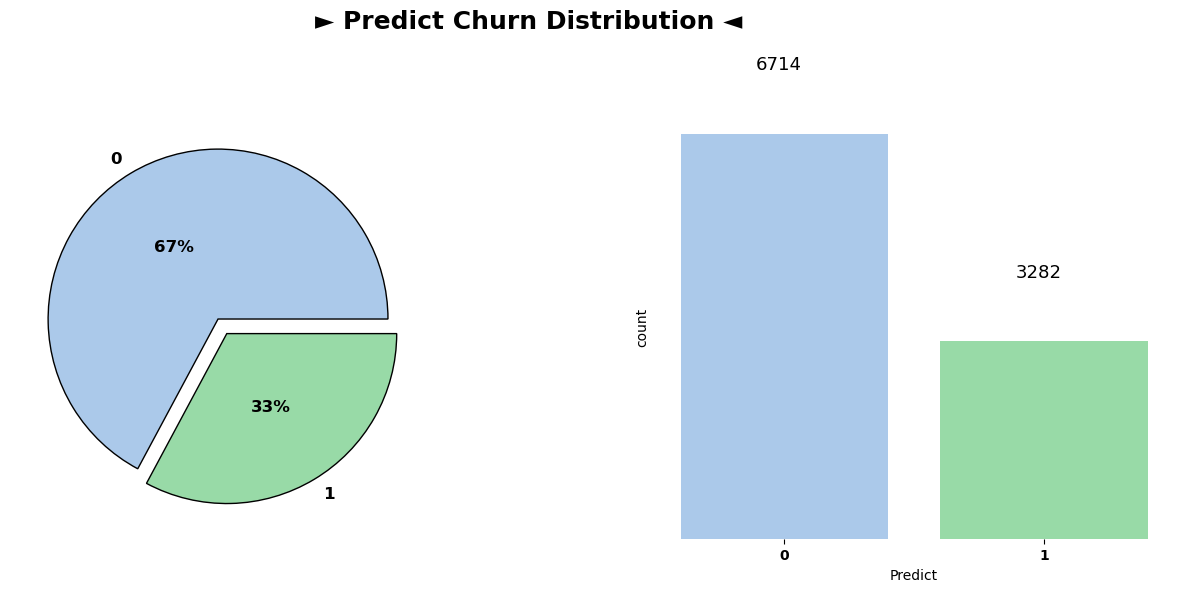

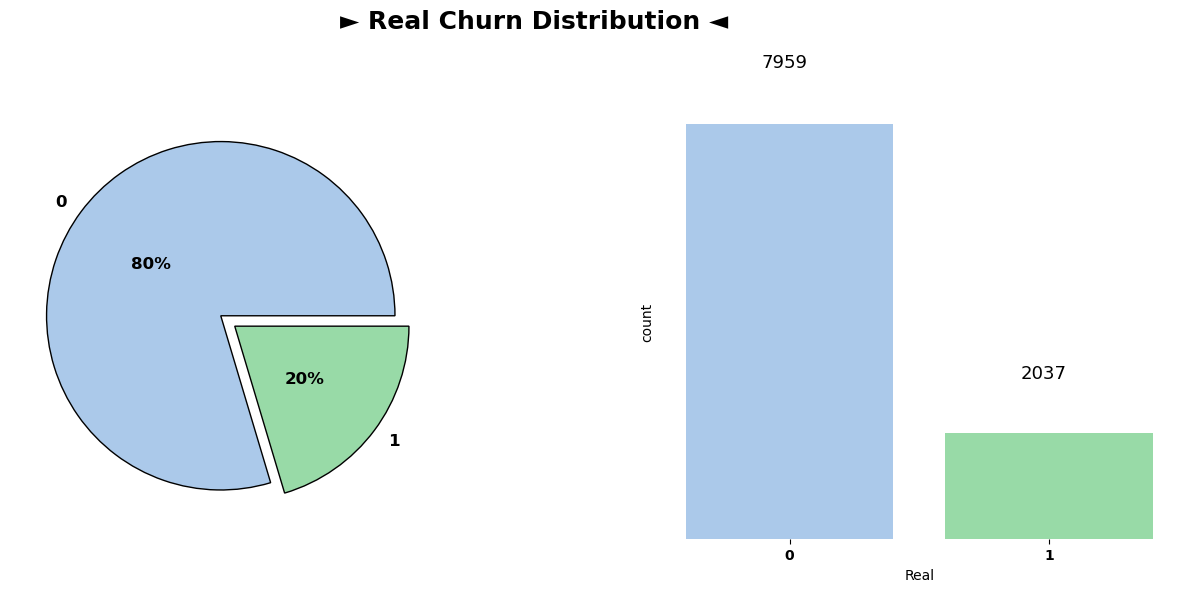

In [61]:
plot_target(result, 
            col=["Predict", "Real"], 
            title="Churn", 
            pie_colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])

- 실제 이탈 지표보다 모델이 예측한 이탈 지표에서 이탈했다고 예측한 사람이 더 많게 나온 것을 볼 수 있다.
- 아무래도 비교적 percision의 성능이 낮고 recall의 성능이 높다보니 1을 정확하게 예측하기보다는 최대한 많은 1을 예측하려고 했기 때문에 1의 지표가 더 많아진 것으로 생각된다.

In [63]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### 이탈별 범주형 변수 분석

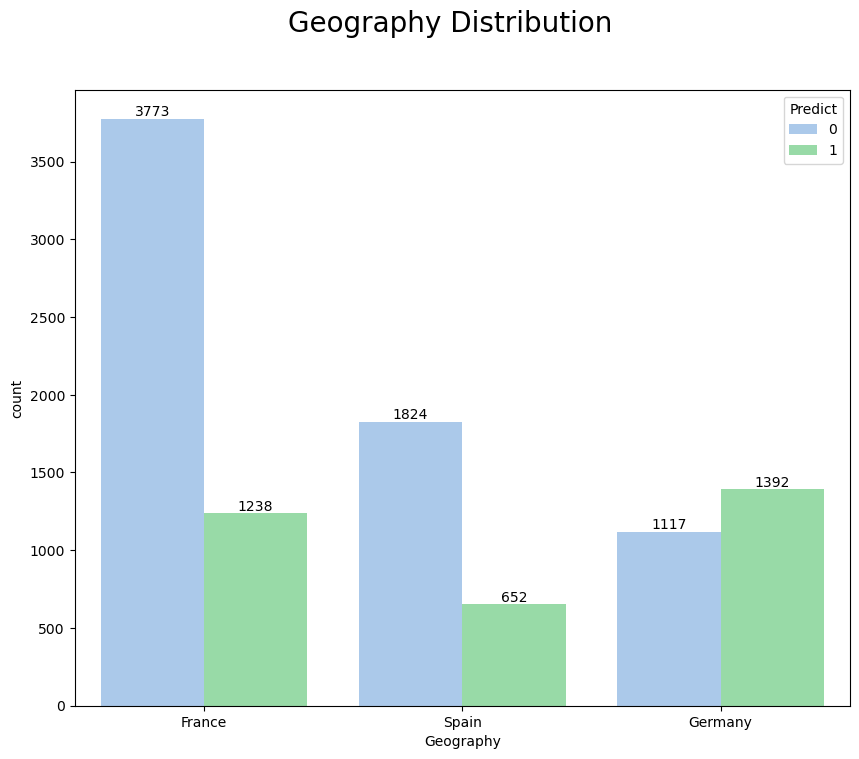

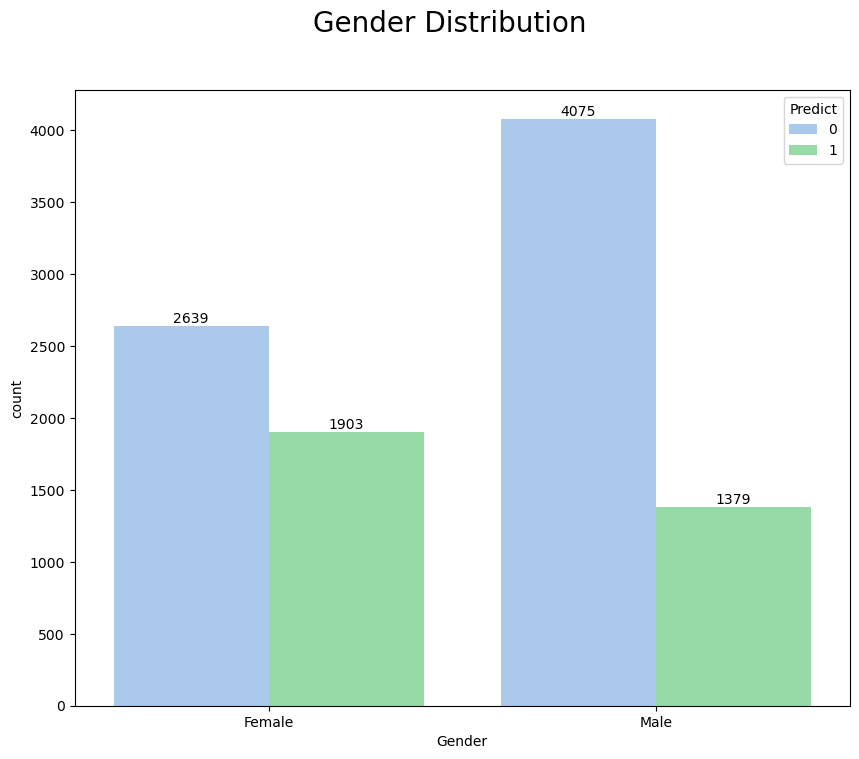

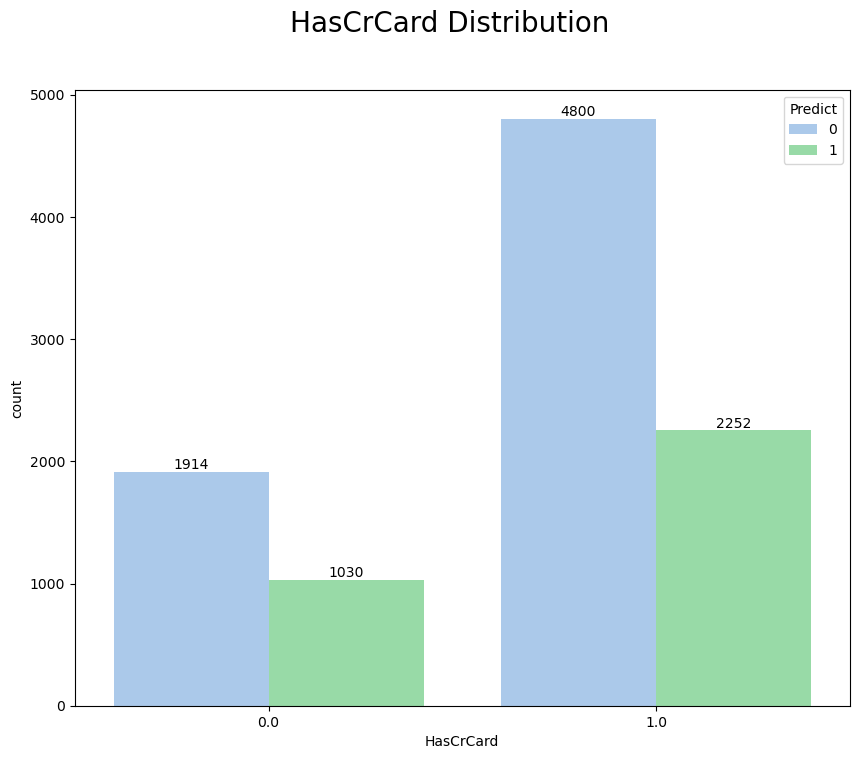

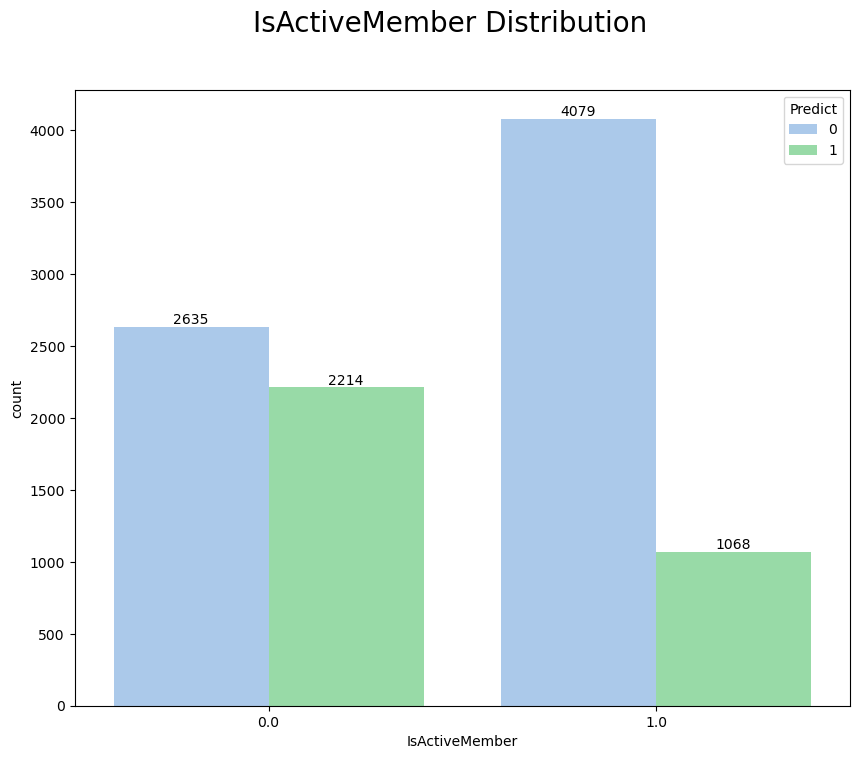

In [65]:
for column in cat_cols:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.countplot(hue="Predict", x=column, data=result, palette="pastel6",)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.suptitle(f'{column} Distribution',fontsize=20)
    plt.show()

- 모델의 특성 중요도 높게 나온 거주지역(독일), 활성멤버, 여성에서의 이탈 비율이 확 높아진 것을 볼 수 있다.


In [66]:
def create_mosaic_plot(df, col1, col2):
    col1_values = df[col1].unique()
    col2_values = df[col2].unique()

    color_palette = plt.cm.get_cmap('Pastel1', len(col1_values))
    colors = {str(val): color_palette(i) for i, val in enumerate(col1_values)}
    
    alphas = np.linspace(0.3, 0.7, len(col2_values))
    alpha_dict = {str(val): alpha for val, alpha in zip(col2_values, alphas)}
    
    def props(key):
        color = colors.get(str(key[0]), (0, 0, 0))
        alpha = alpha_dict.get(str(key[1]), 1)
        return {'color': color[:3] + (alpha,)}

    def labels(key):
        lab1 = {str(val): str(val) for val in col1_values}
        lab2 = {str(val): str(val) for val in col2_values} if col2 != 'Exited' else {'1': 'exited', '0': 'not exited'}

        label = f'{lab1.get(key[0], "unknown")} & {lab2.get(key[1], "unknown")}'
        return label

    fig, ax = plt.subplots(figsize=(16, 8))
    mosaic(df, [col1, col2], properties=props, labelizer=labels, ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(False)
    plt.show()

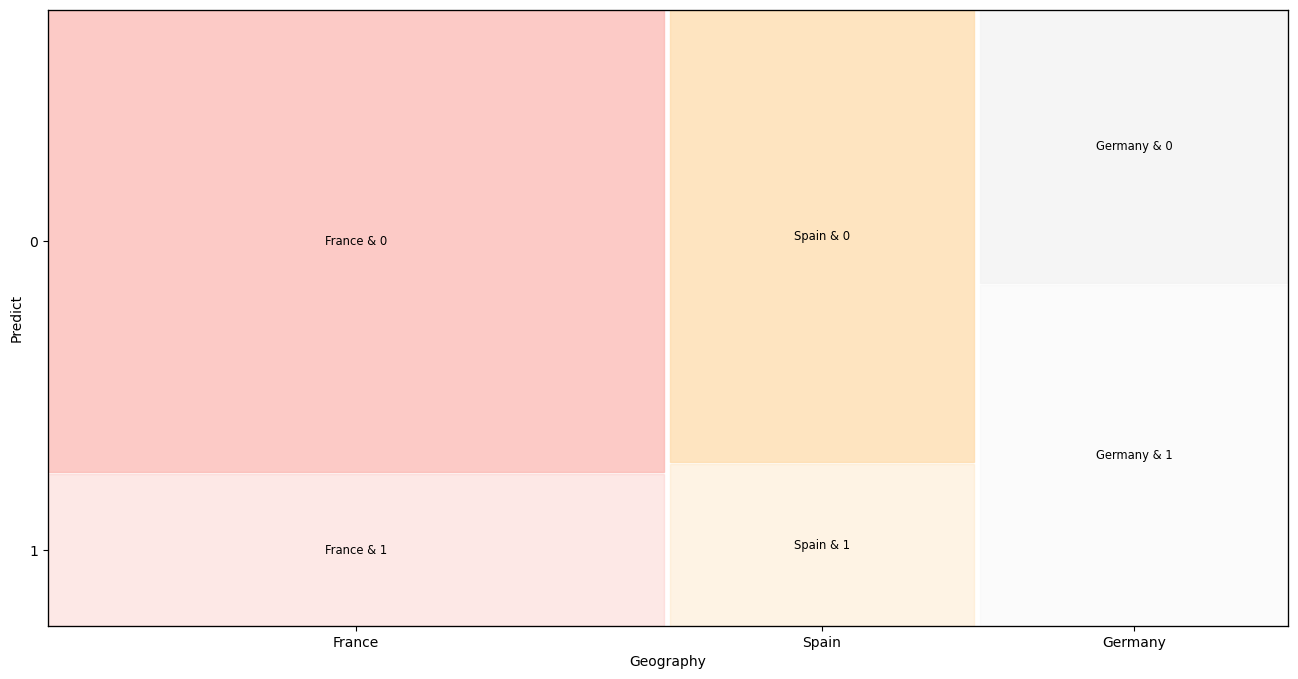

In [68]:
create_mosaic_plot(result, 'Geography', 'Predict')

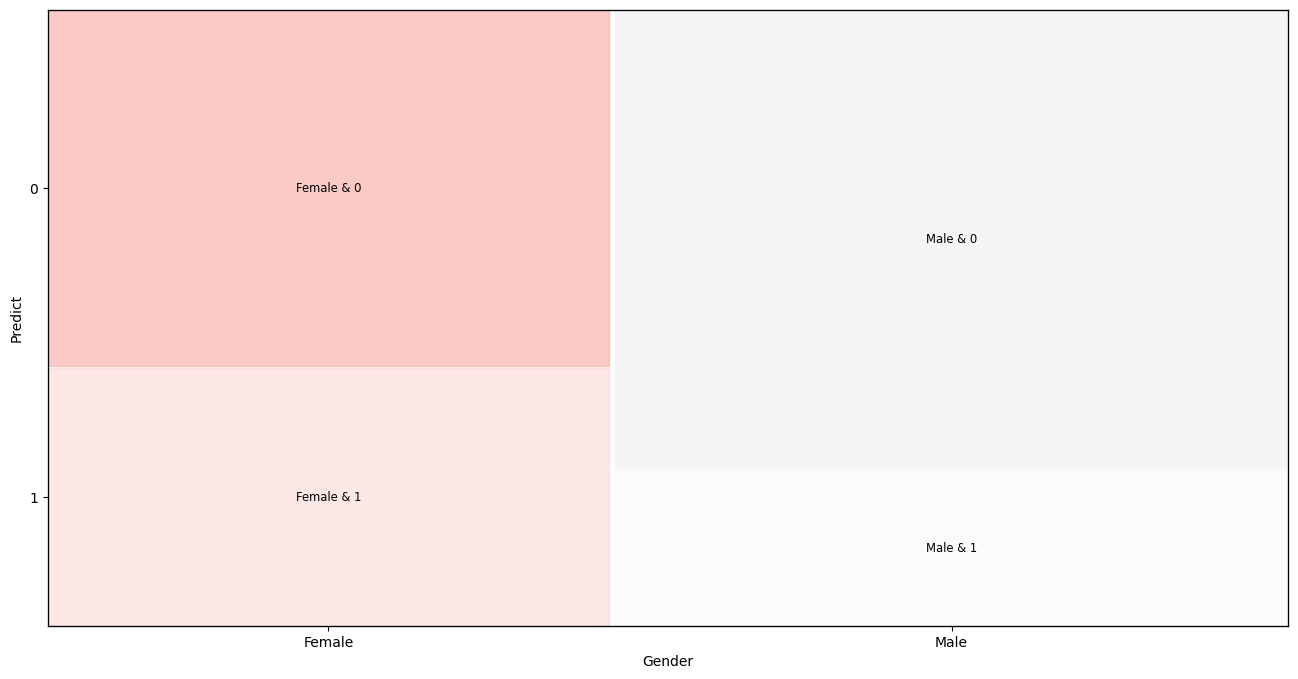

In [70]:
create_mosaic_plot(result, 'Gender', 'Predict')

### 이탈별 수치형 변수 분석

<Figure size 1400x1000 with 0 Axes>

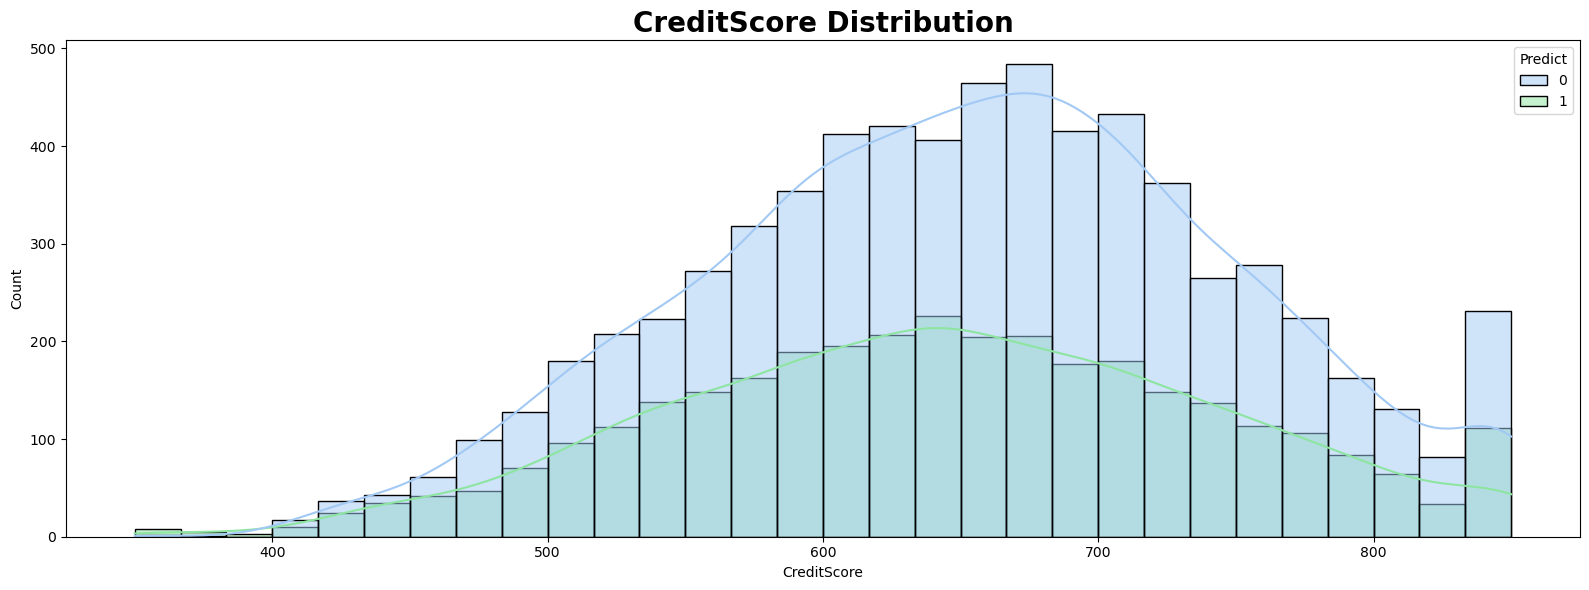

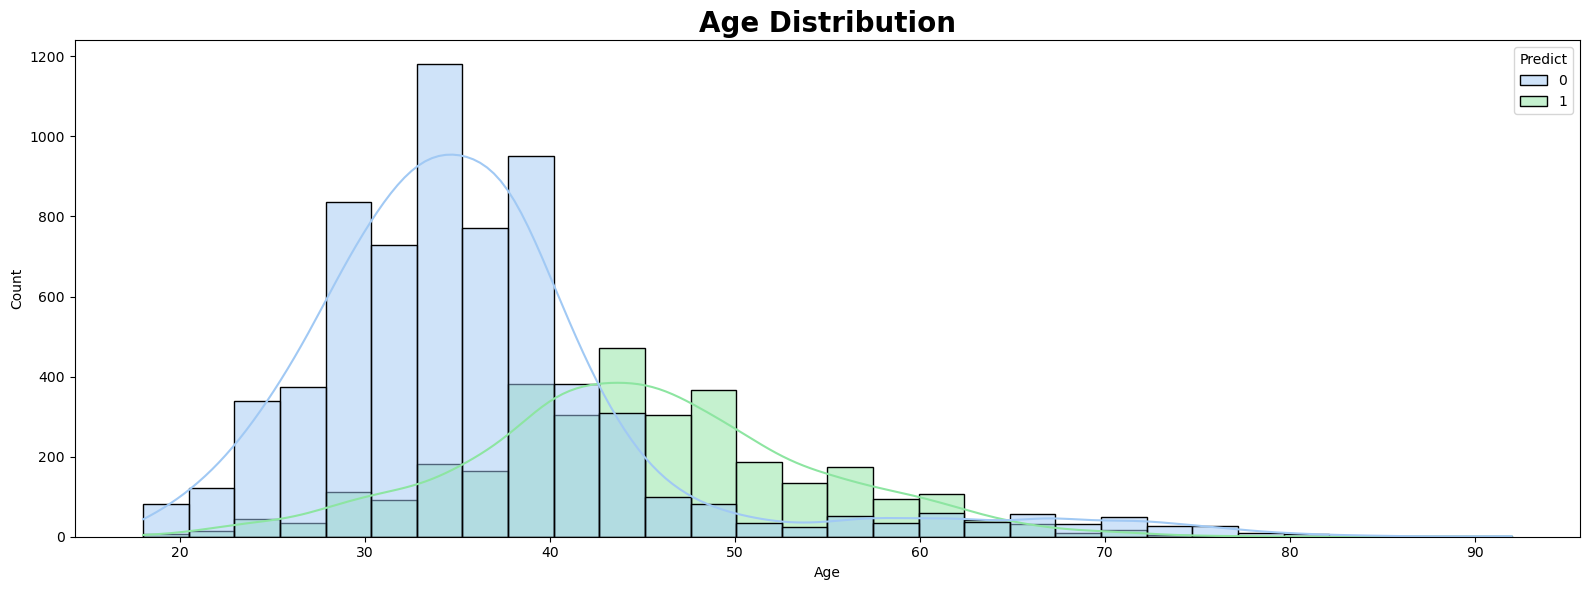

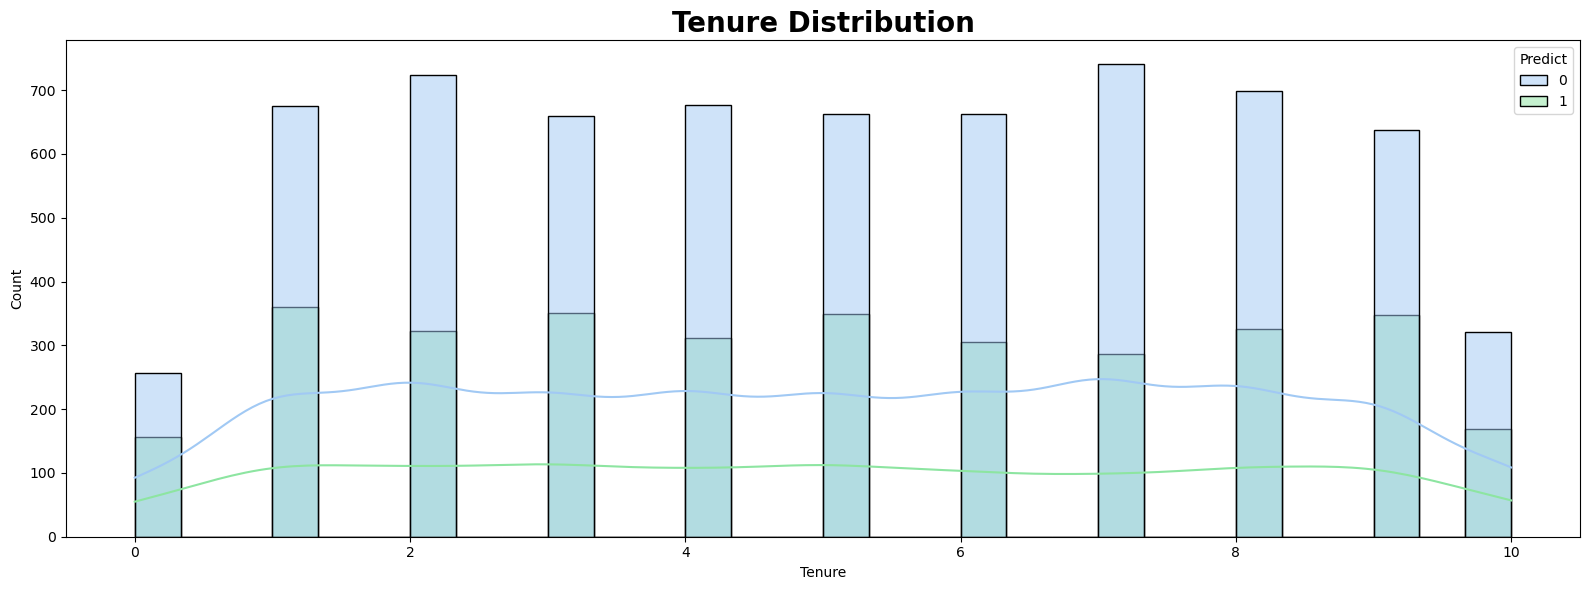

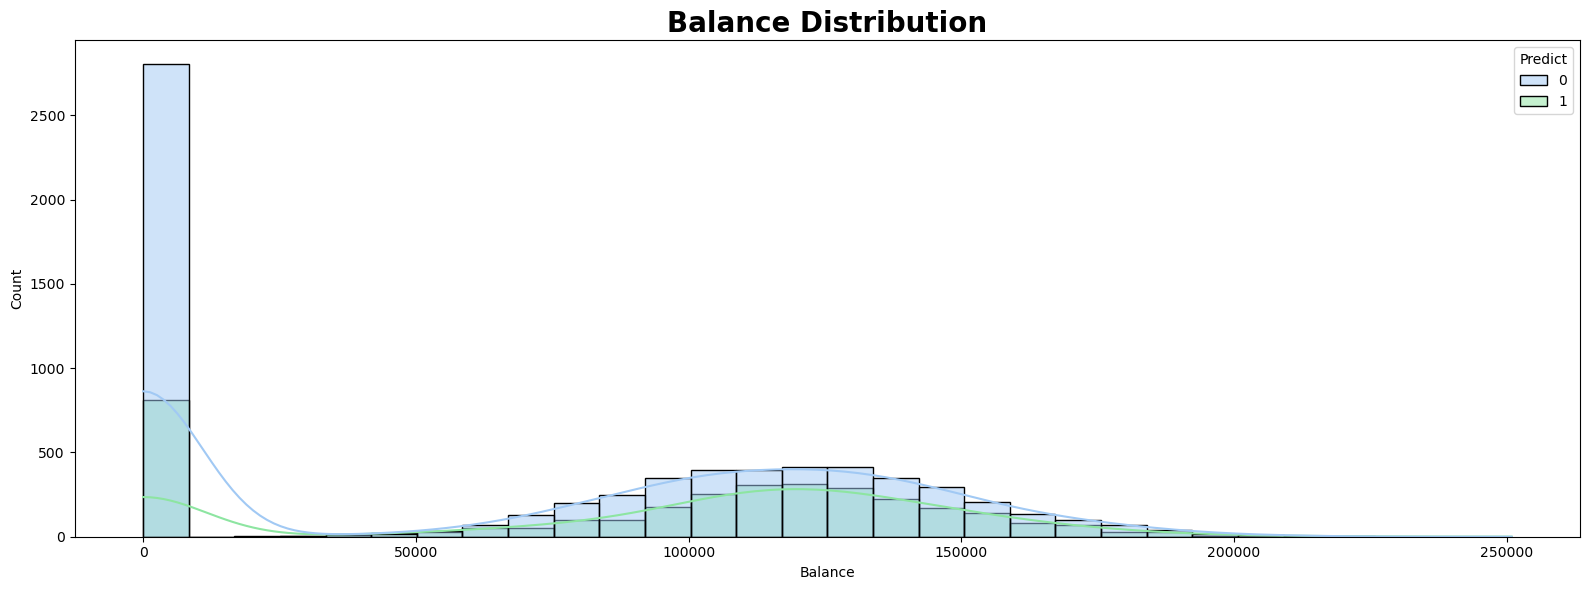

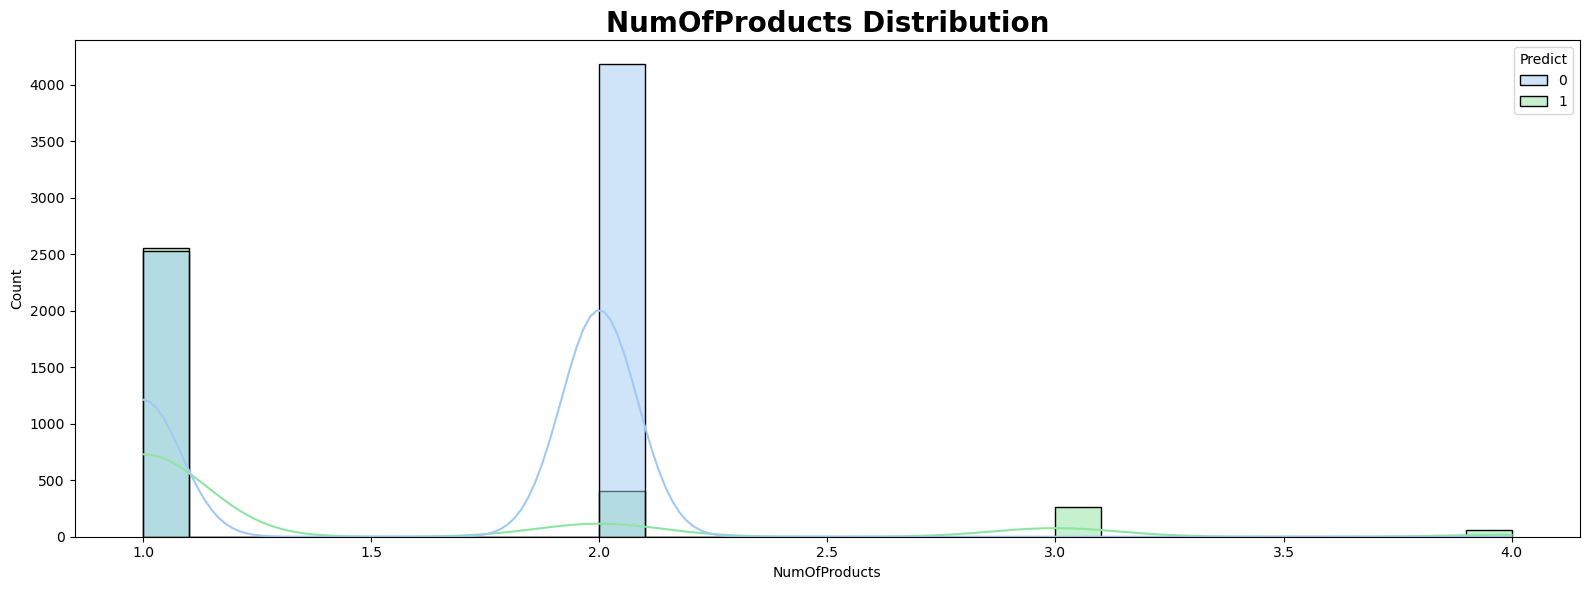

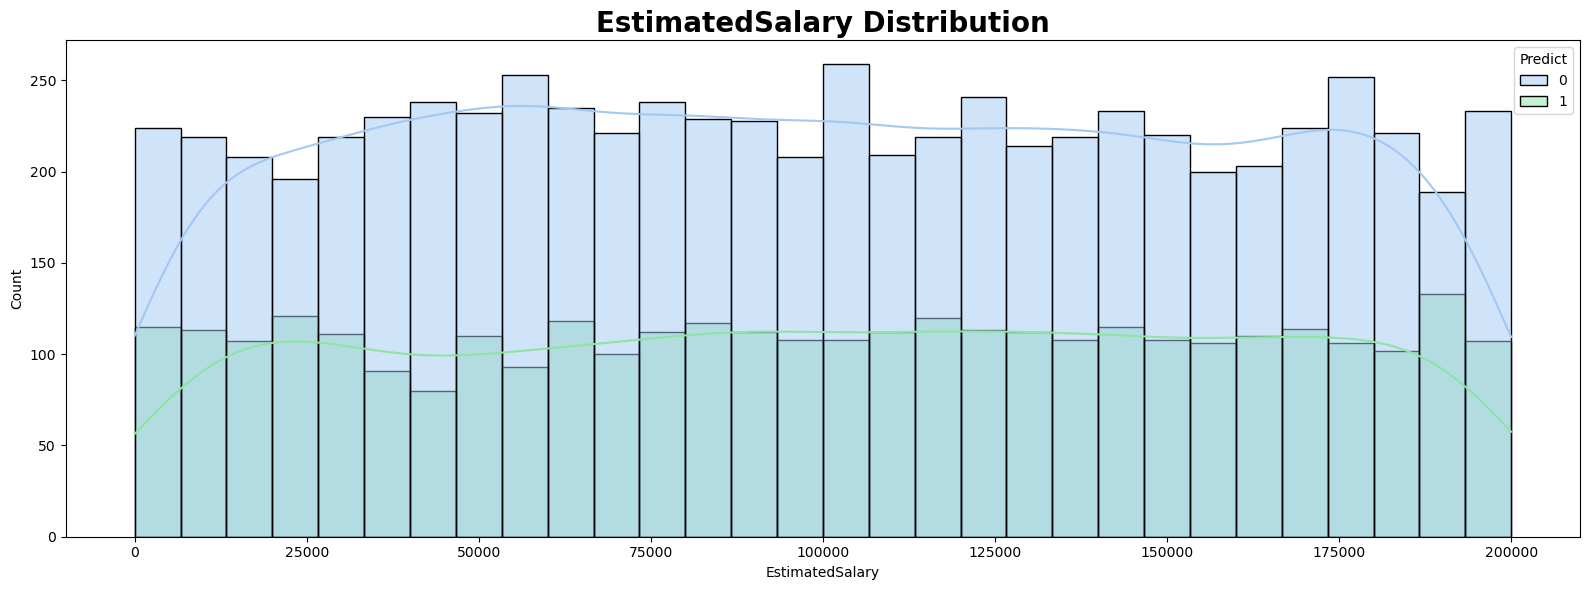

In [73]:
plt.figure(figsize=(14,10))
for idx,column in enumerate(num_cols):
    fig, ax = plt.subplots(figsize=(16, 6))
    fig = sns.histplot(x=column, hue="Predict", data=result,bins=30,kde=True, palette="pastel6")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout();

- 수치형 변수 또한 특성 중요도에서 수치가 높았던 가입 상품 수(1개의 이탈 비율), 나이(40-50, 50-60), 잔고(100000-150000)의 이탈 비율이 많이 높아졌다

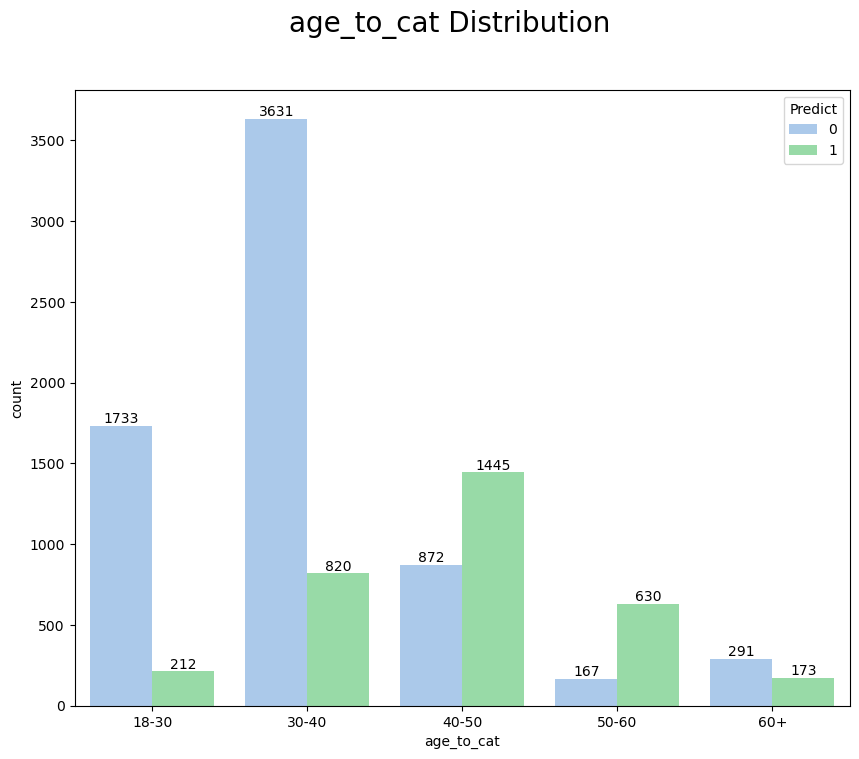

In [76]:
result[''] = pd.cut(result['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(hue="Predict", x='age_to_cat', data=result, palette="pastel6",)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.suptitle('age_to_cat Distribution',fontsize=20)
plt.show()

### 컬럼과의 상관계수 확인

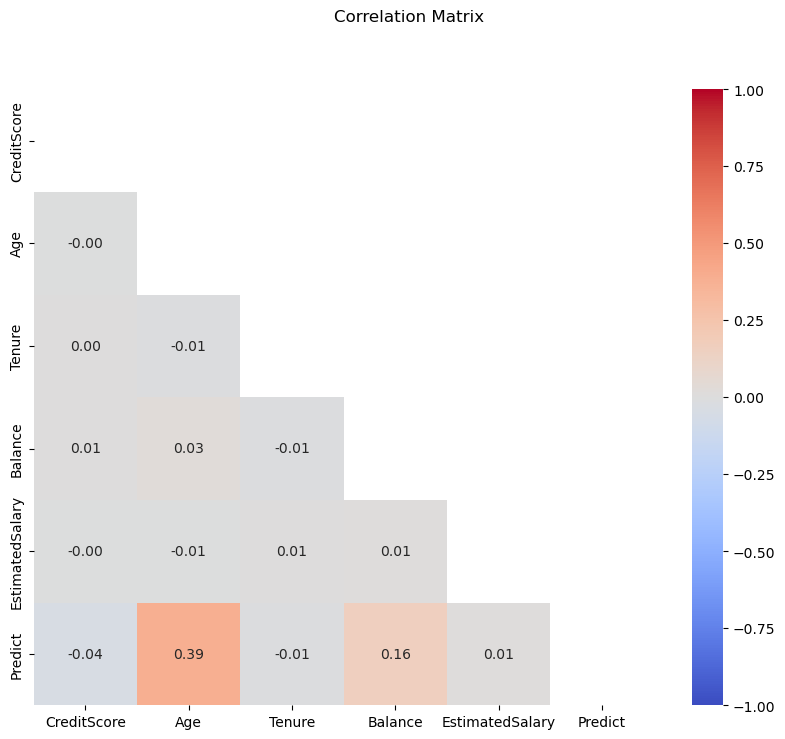

In [81]:
result_digit = result[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Predict']].copy()

corr_matrix = result_digit.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.suptitle('Correlation Matrix')
plt.show()

In [97]:
result_cat_digit = result[['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Predict']].copy()
geo_plus_gen = result[['Geography','Gender']].copy()
geo_plus_gen

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
5,Spain,Male
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


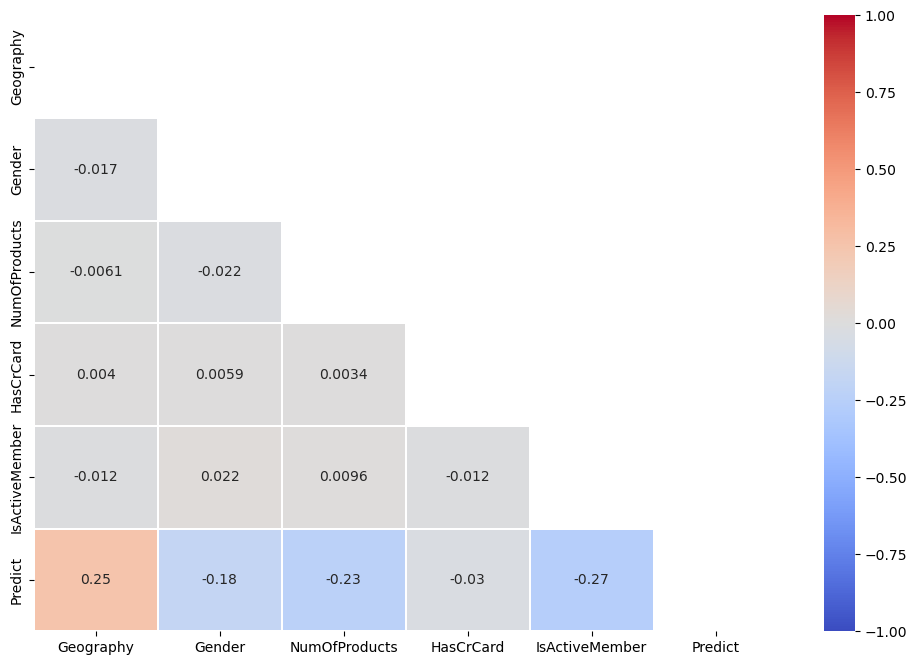

In [98]:
df_cat = geo_plus_gen.apply(lambda x: pd.factorize(x)[0])
df_cat_corr = pd.concat([df_cat, result_cat_digit],axis = 1).corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))
ax = sns.heatmap(df_cat_corr, mask=mask, xticklabels=df_cat_corr.columns, yticklabels=df_cat_corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)